In [1]:
import torch
from torch import nn
import numpy as np

In [10]:
# # IMPORTS FROM THE HARVARD ANNOTATED TRANSFORMER ARTICLE

# !pip install -r requirements.txt

# # Uncomment for colab
# !pip install -q torchdata==0.3.0 torchtext==0.12 spacy==3.2 altair GPUtil
# !python -m spacy download de_core_news_sm
# !python -m spacy download en_core_web_sm

import os
from os.path import exists
import torch
import torch.nn as nn
from torch.nn.functional import log_softmax, pad
import math
import copy
import time

# the paper used learning rate scheduling (see page 7)
from torch.optim.lr_scheduler import LambdaLR 

import pandas as pd
import altair as alt  # visualization library

# used for converting iterator style (eg: lists) datasets to 
# map style (eg: dictionary) datasets
from torchtext.data.functional import to_map_style_dataset

# creates a vocab object (which is a dictionary mapping words to indices) from
# an iterator (eg: list)
from torchtext.vocab import build_vocab_from_iterator

from torch.utils.data import DataLoader
import torchtext.datasets as datasets

import spacy    # NLP library
import GPUtil   # gets GPU status
import warnings

# Sampler that restricts data loading to a subset of the dataset
# It is especially useful in conjunction with torch.nn.parallel.DistributedDataParallel
from torch.utils.data.distributed import DistributedSampler
from torch.nn.parallel import DistributedDataParallel as DDP
import torch.distributed as dist    # distributed communications module
import torch.multiprocessing as mp  # multiprocessing module

# Set to False to skip notebook execution (e.g. for debugging)
warnings.filterwarnings("ignore")
RUN_EXAMPLES = True

**Some convenience helper functions used throughout the notebook.**

In [12]:
def is_interactive_notebook():
    return __name__ == "__main__"


def show_example(fn, args=[]):
    if __name__ == "__main__" and RUN_EXAMPLES:
        return fn(*args)


def execute_example(fn, args=[]):
    if __name__ == "__main__" and RUN_EXAMPLES:
        fn(*args)


class DummyOptimizer(torch.optim.Optimizer):
    def __init__(self):
        self.param_groups = [{"lr": 0}]
        None

    def step(self):
        None

    def zero_grad(self, set_to_none=False):
        None


class DummyScheduler:
    def step(self):
        None

See [this](https://youtu.be/naG4uXpmVAU?si=4O568EkC4zqwpYwW) video to know the difference between shallow copy and deep copy in python.

### Code Skeleton

The code for the transformer architecture will look something like this:

```python
class Transformer(nn.Module):
    def __init__(self, ...):
        ...
    
    # other functions like input_embedding, positional_encoding, layer_norm, etc.
    
    def EncoderBlock(self, inputs):
        ...
    
    def DecoderBlock(self, outputs, inputs):
        ...
        
    def ClassifierHead(self, vector):
        ...
```

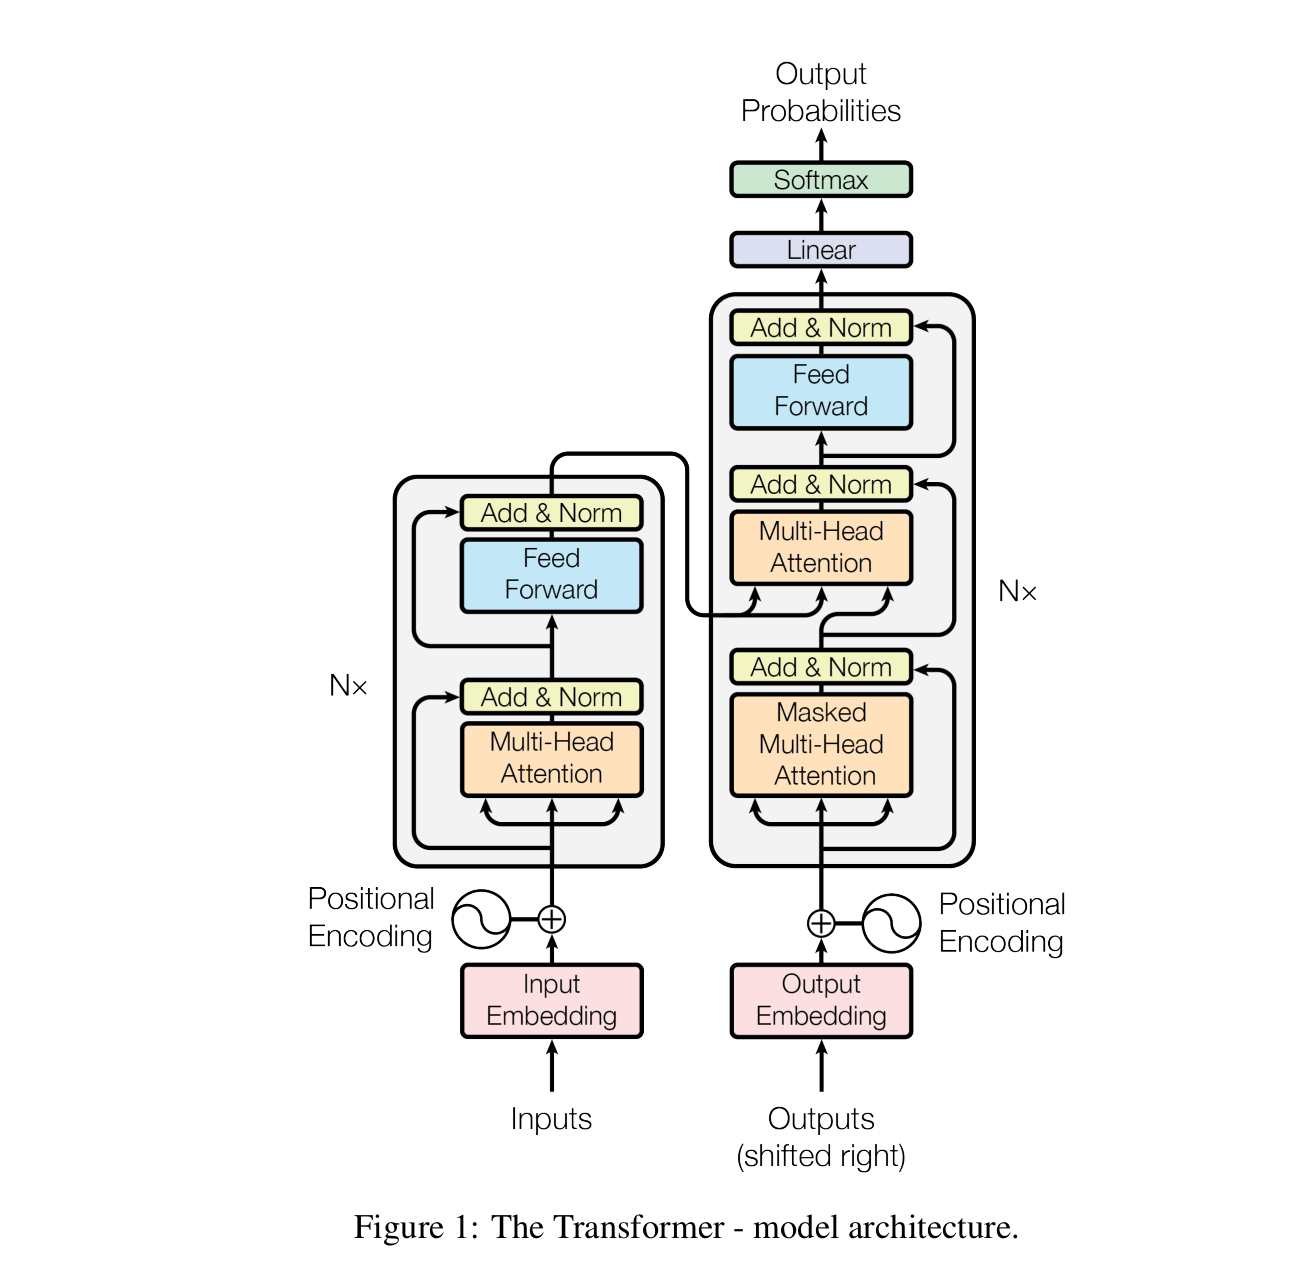

# A quick walkthrough of the Transformer architecture


First we deal with the encoder block on the left. We take inputs (source or input sequence) and create their embeddings. These input embeddings don't contain any information on the position of the words, which is very important in a sentence. So, we manually insert the information about the position of the words using positional encoding. Both the input embedding and positional encoding are vectors. We add these 2 vectors. We take a copy of this resulting vector, say x, and keep it aside. We obtain the queries, keys, and values, and send them to the multi-head self-attention layer. The output of this multi-head attention is a vector, say z. Now, we add z and x. This is the residual or skip connection step (which is depicted in the model diagram by "Add"). The benefits of residual connection is that it helps build deep layered models (ie, models with a lot of layers) and helps prevent the gradient vanishing problem. Now, we take the layer normalization of them. Normalization makes the training faster and sometimes gives better results. It also helps prevent the gradient exploding problem. The output of this layer is a vector, say x. We send this to a point-wise feed-forward network. The output of this network is a vector, say z. We add z and x. This is again the residual or skip connection. We take the layer normalization of this resulting vector. Then we send this vector and generate the queries, keys, and values, and send them to the decoder.

Now, we deal with the decoder block on the right. We take the outputs (target sequence) and shift them right, ie, add a start of sequence token (`<sos>`) in the beginning of the output sequence. Then we create embeddings of the output sequence. We also create the positional encoding of the output sequence. Both the output embedding and positional encoding are vectors. We add these 2 vectors. We take a copy of this resulting vector, say x, and keep it aside. We obtain the queries, keys, and values, and send them to the masked multi-head self-attention layer. The new "mask" thing in the multi-head self-attention layer restricts the decoder to look at the current and previous tokens of the target sequence during the testing phase. The decoder cannot look at the tokens beyond the current token of the target sequence during the testing phase. However, the decoder can look at the entire target sequence during the training phase. The output of this masked multi-head attention is a vector, say z. Now, we add z and x. This is the residual or skip connection step. Now, we take the layer normalization of them. We take a copy of this resulting vector, say x, and keep it aside. We obtain the queries, keys, and values using this vector. Now, recall how we generated queries, keys, and values at the end of the encoder block processing. We take the keys and values of the encoder, and the queries of the decoder. Now, we send them to the multi-head self-attention layer (no mask this time). The output of this multi-head attention is a vector, say z. Now, we add z and x. This is the residual or skip connection step. Now, we take the layer normalization of them. The output of this layer is a vector, say x. We send this to a point-wise feed-forward network. The output of this network is a vector, say z. We add z and x. This is again the residual or skip connection. We take the layer normalization of this resulting vector. The output of this layer is again a vector. This was all for the decoder block.

Now, we come to the classifier head. We pass the output vector of the decoder block to a linear layer in the decoder block. The output of this linear layer is then sent to a softmax function, which produces the output probabilities.

Note: there 6 stacks of encoder and decoder blocks each.

A very superficial way to translate the above theory to code is the following (this is just to make things concrete):

```python
class Transformer(nn.Module):
    def __init__(self):
        ...
    
    def input_embedding(self, vector):
        ...
        
    def output_embedding(self, vector):
        ...
    
    def positional_encoding(self, vector):
        ...

    def get_qkv(self, inputs):
        ...
       
    def multi_head_attention(self, q,k,v):
        ...

    def layernorm(self, vector):
        ...

    def feed_forward_network(self, vector):
        ...
    
    def masked_multi_head_attention(self, q,k,v):
        ...
        
    def linear_layer(self, vector):
        ...
    
    def EncoderBlock(self, inputs):
        x1 = self.input_embedding(inputs)
        x2 = self.positional_encoding(inputs)
        x = x1 + x2
        q, k, v = self.get_qkv(x)
        z = self.multi_head_attention(q,k,v)
        z = z + x
        x = self.layernorm(z)
        z = self.feed_forward_network(x)
        z = z + x
        z = self.layernorm(z)
        return self.get_qkv(z)
        
    def DecoderBlock(self, inputs, outputs):
        sos_token = ... # some token (number)
        # shift outputs to the right by attaching a start of sequence token at the
        # starting of the output sequence
        outputs = np.concatenate((sos_token, outputs))
        x1 = self.output_embedding(outputs)
        x2 = self.positional_encoding(outputs)
        x = x1 + x2
        q, k, v = self.get_qkv(x)
        z = self.masked_multi_head_attention(q,k,v)
        z = z + x
        x = self.layernorm(z)
        q, _, _ = self.get_qkv(z)
        # get the keys and values of the encoder block
        _, k, v = self.EncoderBlock(inputs)  
        z = self.multi_head_attention(q,k,v)
        z = z + x
        x = self.layernorm(z)
        z = self.feed_forward_network(x)
        z = z + x
        z = self.layernorm(z)
        return z
        
    def ClassifierHead(self, vector):
        z = self.linear_layer(vector)
        return torch.softmax(z, dim=1)
    
    def forward(self, inputs, outputs):
        z = self.DecoderBlock(inputs, outputs)
        output_probs = ClassifierHead(z)
        return output_probs
```

**TODO:**

- check what the inputs and outputs are exactly -- are they vectors or tokens or what
- include an explanation on embeddings
- include an explanation on positional embeddings
- include an explanation on how queries, keys, and values are obtained or generated
- include an explantion on what multi-head self-attention is
- include an explantion on what masked multi-head self-attention is
- include an explantion on hows layer normalization work
- include an explantion on the working of the point-wise feed-forward network
- include an explantion on the linear layer

We need to initialize the inputs... (add relevant information)

### Input Embedding

### Positional Encoding

Position of a word in a sentence is very important. For example, the following 2 sentences contain the same words but have entirely opposite meanings due to the different order of the words: "The man killed the lion" and "The lion killed the man".

The input embedding does not store the position of the words in the sentence. So, we manually insert the position information using positional encoding.

The formula used in the paper for positional encoding is:

$$PE_{(pos, 2i)} = sin\left(\frac{pos}{10000^{\frac{2i}{d_{model}}}}\right)$$

$$PE_{(pos, 2i+1)} = cos\left(\frac{pos}{10000^{\frac{2i}{d_{model}}}}\right)$$

, where $pos$ is the position and $i$ is the dimension.


<br></br>

Q. **Explain why this type of positional encoding was chosen?**

A. 

In [5]:
def positional_encoding(pos, i):
    d_model = 512  # fixed for the entire transformer architecture
    denominator = np.power(10000, 2*i/d_model)
    if i%2==0:  # if the dimension is even, use sin
        return np.sin(pos/denominator)
    else:       # if the dimension is odd, use cos
        return np.cos(pos/denominator)

### Queries, Keys, Values (QKV)

QKV is a concept borrowed from the field of information retrieval systems. To understand their meaning, consider this analogy: you want to see a deep learning video on youtube, so you open it and search "deep learning". This "deep learning" is your query. Now, youtube will show you some results of videos on deep learning. These results are the keys. Finally, 
we perform something called an attention score on these "keys" using the query in order to find the most relevant answer to our query from among the keys presented. The most relevant video that we get is the value. This analogy was taken from [here](https://youtu.be/ySEx_Bqxvvo?si=3kNs7YrDm10dSbXA).

### Self-Attention

$$Attention (Q,K,V) \;=\; softmax \left( \frac{QK^T}{\sqrt{d_k}} \right) V $$

, where $d_k$ is the dimensionality (size or length of the vector) of $Q$ or $K$ or $V$ (as they are all of the same size). In this paper, $d_k = 512$.

Some extra information:

$$softmax(z)_i = \frac{e^{z_i}}{\sum_{j=1}^N e^{z_j}} $$

, where:
- $softmax(z)_i$ is the softmax of the i-th element of the vector z
- N is the length of the vector z

The code for the softmax function is simply:
```python
def softmax(vector):
    e = np.exp(vector)
    output = e / e.sum()
    return output
```

**Q. Explain why self-attention was used?**

A. check pages 6,7 of the paper.

In [3]:
def attention(q, k, v):
    d_k = len(q)  # should be 512
    numerator = np.dot(q, k.T)
    denominator = np.sqrt(d_k)
    output = torch.softmax(product/denominator, dim=1)
    return torch.matmul(output, v)

### Multi-Head Attention

### Feed-Forward Network

In [2]:
def feed_forward_network(x):
    """
    param x: a vector
    
    Returns max(0, x*W1 + b1)*W2 + b2,
    where W1, b1, W2, b2 are weights and biases matrices and vectors.
    """
    # these are taken from page 5 of the paper
    z = nn.Linear(512, 2048)(x)
    z = nn.ReLU()(z)
    z = nn.Linear(2048, 512)(z)
    return z

### The Entire Encoder Block

### Masked Multi-Head Attention

### The Entire Decoder Block

### Classifier Head

### Entire Transformer Architecture

# References:

A big part of this notebook has been inspired and taken from the [harvard annotated transformer article](https://nlp.seas.harvard.edu/annotated-transformer/).

I used the following resources to write this notebook:
- 